In [1]:
import numpy as np
import fiducial as fid
import matplotlib.pyplot as plt
import utils as u
import Eg_cov as egcov
import joint_cov as jp
import pyccl.nl_pt as pt

This notebook gets the linear scale cuts when we implement a correction for nonlinear galaxy bias on the basis of measuring some best-fit parameters for some model of nonliner galaxy bias.

Set up parameters etc

In [2]:
lens = 'DESI'
src = 'LSST'

Pimax=300.
#rp_bin_edges = np.logspace(np.log10(rp0), np.log10(50.), 11)
endfilename='_Nov_2024'
#rp_bin_c = u.rp_bins_mid(rp_bin_edges)
# Let's use the same cosmological parameters as Shadab's simulations:
h=0.69
OmB = 0.022/h**2

# Using nonlinear bias parameters as fit in Kitanis & White 2022. These will be the best-fit values / mean posterior values.
# They fit LPT parameters so we convert these to their Eulerian equivalents.
b1_LPT = 1.333
b2_LPT = 0.514
bs_LPT = 0 # They fix this to 0.

# Set up some stuff from where we sample from the bias parameter posterior later:
# bias par means from Kitanidis & White:
bias_means = [b1_LPT, b2_LPT]

bias_cov = np.zeros((2,2))
bias_cov[0,0] = 0.0016
bias_cov[1,1] = 0.0650
bias_cov[0,1] = -0.005
bias_cov[1,0] = -0.005

# Convert to Eulerian using the conversions in Chen, Vlah & White 2020 (these use the same convention as Kitanis & White 2022)
b1 = 1.0 + b1_LPT
b2 = b2_LPT + 8./21.*(b1_LPT)
bs = bs_LPT - 2./7*(b1_LPT)

#b1 = 2.03
#b2 = 0.9*(b1-1.0)**2-0.5 # From Fast-PT example notebook which says 
#'(this is a numerical fit to simulation k2Pnl1_regdata, but a relationship of this form is motivated in the spherical collapse picture'
#bs = -4.0/7.0*(b1-1.0) # The 'coevolution value' see Pandey et al. DES Y3 papers

params = {'mu_0': 0., 'sigma_0':0., 'OmB':OmB, 'h':h, 'n_s':0.965, 'A_s':2.115 * 10**(-9),'b':b1, 'OmM': 0.292, 'b_2':b2, 'b_s': bs} 



Set up the projected radial bins.

In [3]:
rp0 = 1.5

rp_bin_c_raw = np.loadtxt('../data_for_Danielle/test-HOD-PB00-z0.75-w1pz_cat-zRSD-model-5-gxm-sel-crossparticles-wtag-w1-rfact10-bin1-wp-logrp-pi-NJN-100.txt.upsilon')[:,0]
rp_bin_edges_raw = u.rp_bin_edges_log(rp_bin_c_raw)
#Cut below rp0 making sure rp0 is in the lowest bin. Go one bin lower because this 
ind = next(j[0] for j in enumerate(rp_bin_edges_raw) if j[1]>rp0)-1
rp_bin_c = rp_bin_c_raw[ind:]
rp_bin_edges = rp_bin_edges_raw[ind:]

print('rp bin c=', rp_bin_c)
print('rp bin edges=', rp_bin_edges)

rp bin c= [ 1.39357881  1.83709466  2.42176242  3.19250463  4.20854074  5.54793718  7.31360558  9.64120984 12.70958983 16.75450244 22.08673575 29.11598823 38.38234769 50.59778848 66.70087562 87.92887875]
rp bin edges= [  1.21375641   1.60004256   2.10926689   2.78055529   3.66548575   4.83205129   6.36988417   8.39714273  11.06958999  14.5925616   19.23674266  25.35896564  33.42962733  44.0688315   58.09403408  76.5828519  100.95586057]


Now try computing the sample covariance matrix for the correction factor by sampling over the bias posterior. This takes a little while so if we've computed it already just load it from file.

In [4]:
Nsamps = 500

#Cb_cov = egcov.cov_bias_corr(params,bias_means,bias_cov, rp_bin_edges,rp_bin_c, rp0, lens, src, Pimax, Nsamps, endfilename)
#np.savetxt('../txtfiles/Cb_cov_500samples_Nov28.dat', Cb_cov)

Cb_cov = np.loadtxt('../txtfiles/Cb_cov_500samples_Nov28.dat')

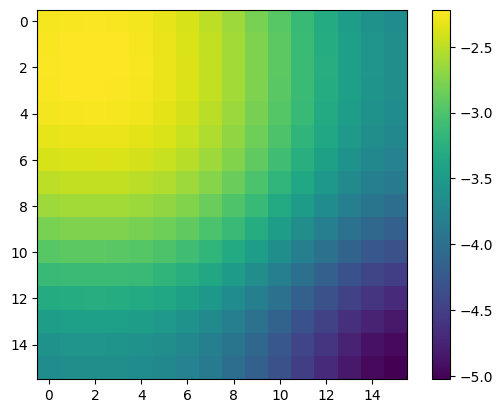

In [7]:
plt.figure()
plt.imshow(np.log10(Cb_cov))
plt.colorbar()
plt.show()

Get data covariance matrix for E_G.

In [5]:
#Dcov_eg = egcov.get_egcov(params, rp_bin_edges, rp_bin_c, rp0, lens, src, Pimax, Nsamps, endfilename)
#np.savetxt('/home/danielle/Documents/CMU/Research/EG_comparison/txtfiles/Dcov_eg_'+endfilename+'.txt', Dcov_eg)
Dcov_eg = np.loadtxt('../txtfiles/egcov_sims_wSN_Oct24.txt')

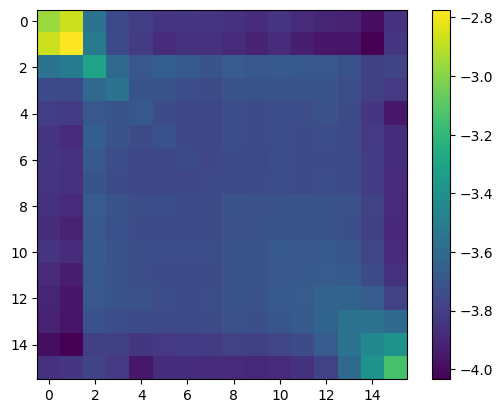

In [9]:
plt.figure()
plt.imshow(np.log10(Dcov_eg))
plt.colorbar()
plt.show()

Now combine the two to get the covariance for the corrected E_G.

In [6]:
cov_EG_corr= egcov.corrected_EG_cov(params, Dcov_eg, Cb_cov, rp_bin_edges, rp_bin_c, rp0, lens, src, Pimax, endfilename)

bias correction: getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
bias correction: getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356


Get the linear and nonlinear datavector for the bias-corrected E_G. We are going to do this a bunch of times, drawing from the posterior of the bias parameters, to get a spread of answers. But let's just implement a single case at the mean values for now.

In [7]:
# Get linear datavector - this has no correction because the correction is explicitly for nonlinear effects.
data_lin_EG = fid.E_G(params, rp_bin_edges, rp0, lens, src, Pimax, endfilename, nonlin=False)

getting Upgg
getting Upgm
maxchi= 6669.353003473356


For the nonlinear data vector, we need to do a few draws of bias parameters from the truth posterior when computing the 'raw' E_G. This takes care of the fact that the correction will not be perfect. 

In [8]:
# First get C_b at the mean values - this is the same even when we implement a draw for the bias parameters in the raw E_G.
C_b_mean = fid.bias_correction(params, rp_bin_edges, rp0, lens, src, Pimax, endfilename)

bias correction: getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
bias correction: getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356


b1= 2.313531912071797 b2= 1.4278122741236927 bs= -0.37529483202051345
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
(16,)


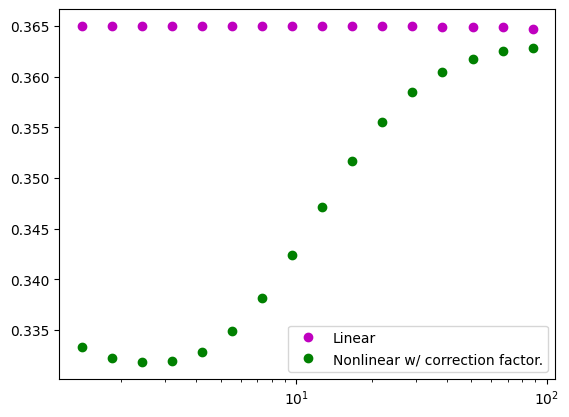

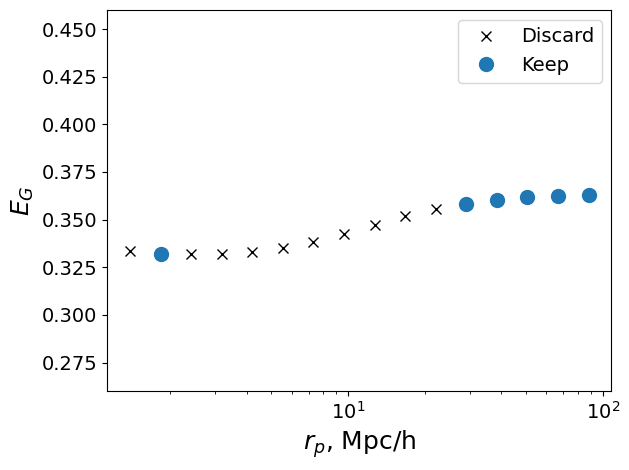

b1= 2.365430191097342 b2= 1.2248172750057496 bs= -0.3901229117420977
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
(16,)


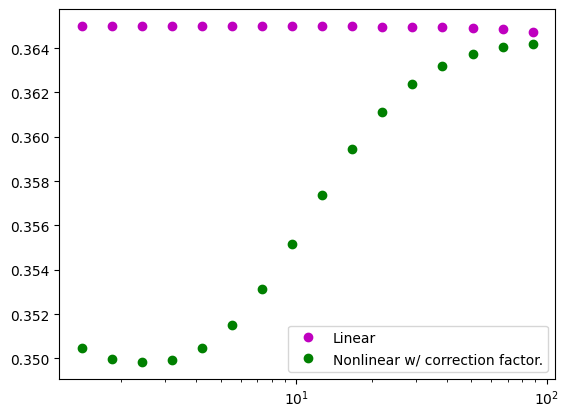

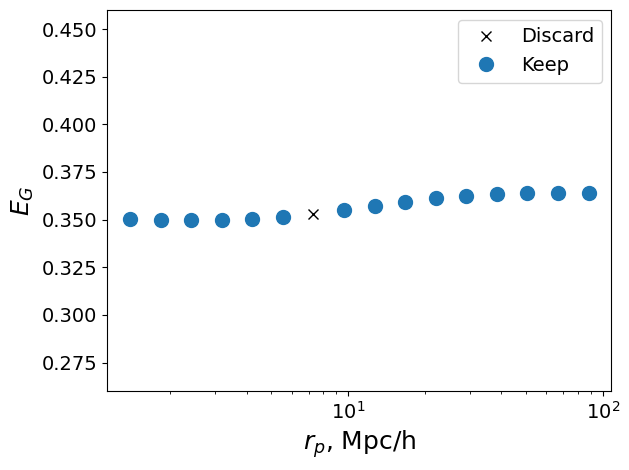

b1= 2.3023848264181255 b2= 1.5389246913623968 bs= -0.3721099504051787
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
(16,)


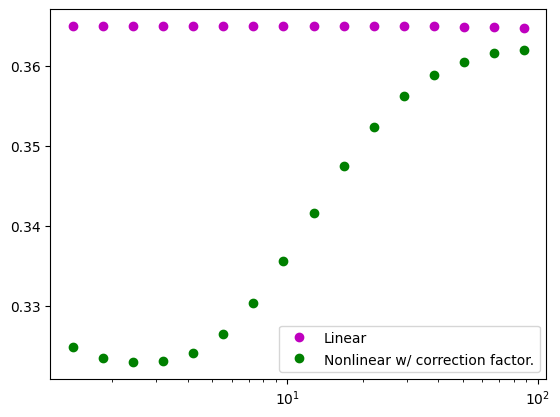

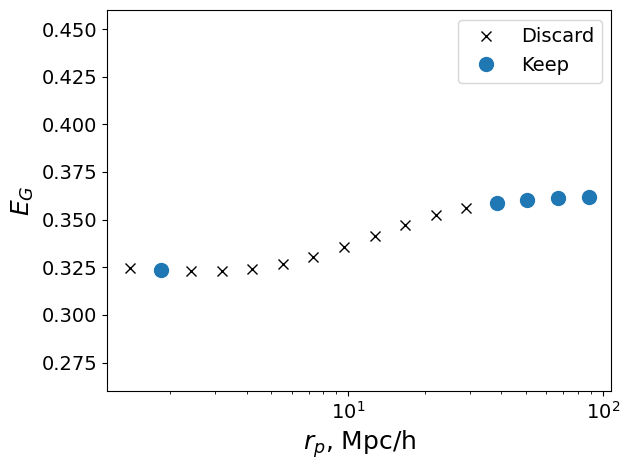

b1= 2.3371515612772296 b2= 0.8467534704278091 bs= -0.3820433032220656
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
(16,)


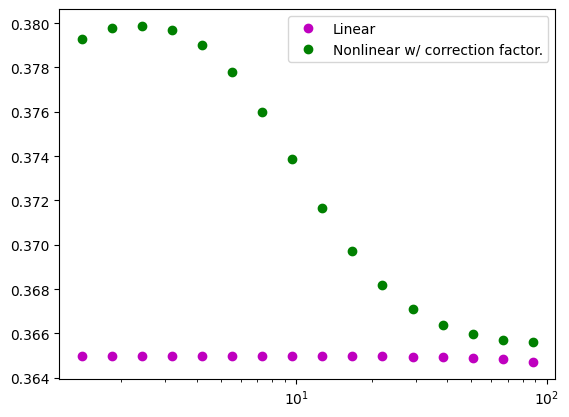

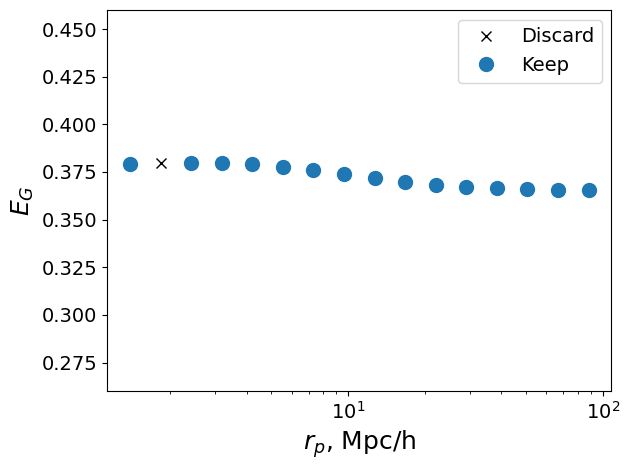

b1= 2.3342474344961075 b2= 0.766437469260139 bs= -0.38121355271317353
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
(16,)


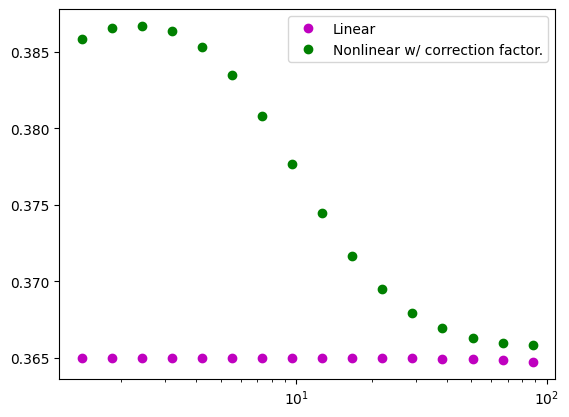

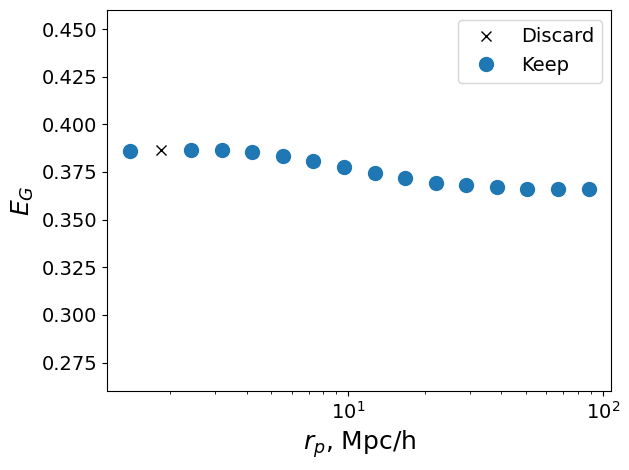

b1= 2.3255919597027144 b2= 1.0518896056767133 bs= -0.3787405599150612
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
(16,)


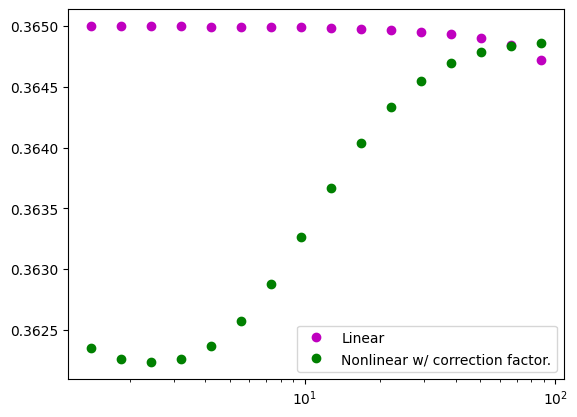

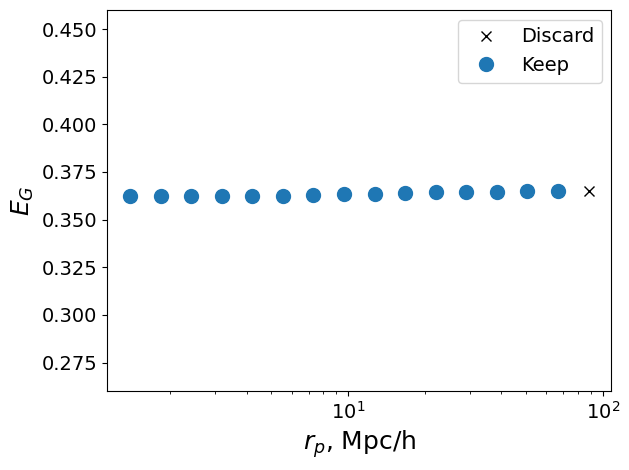

b1= 2.323164219252351 b2= 0.9113416923966606 bs= -0.37804691978638605
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
(16,)


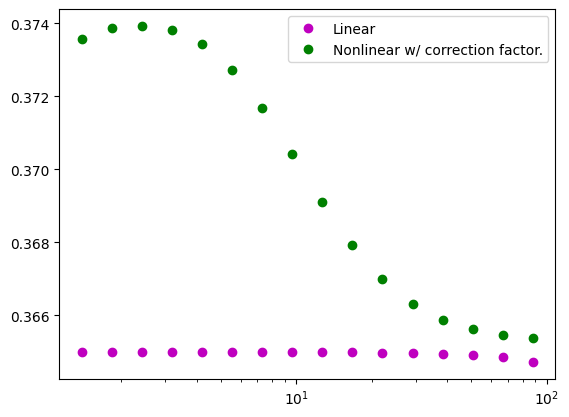

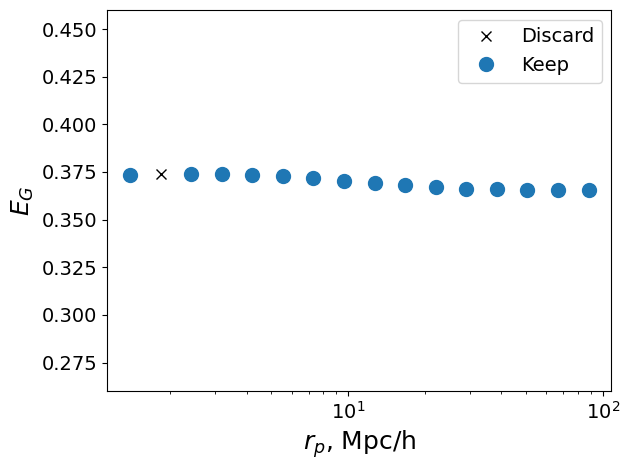

b1= 2.339576763047452 b2= 0.928343878093457 bs= -0.3827362180135577
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
(16,)


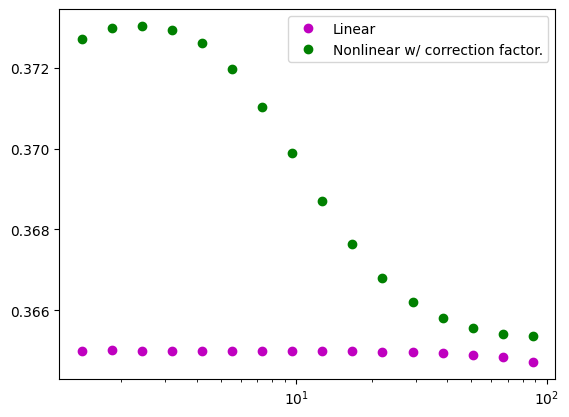

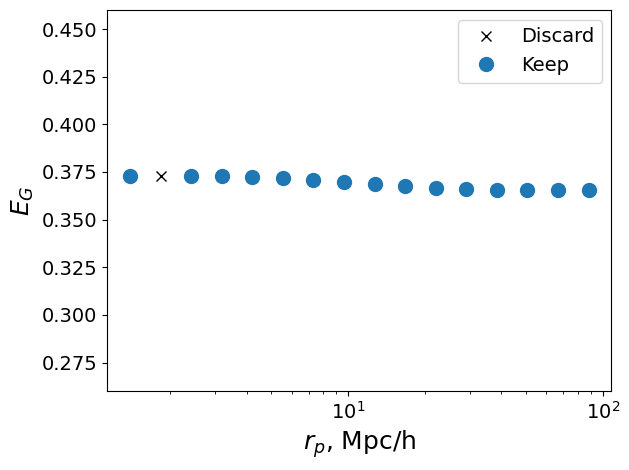

b1= 2.3006720210704623 b2= 1.0110734661605605 bs= -0.3716205774487036
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
(16,)


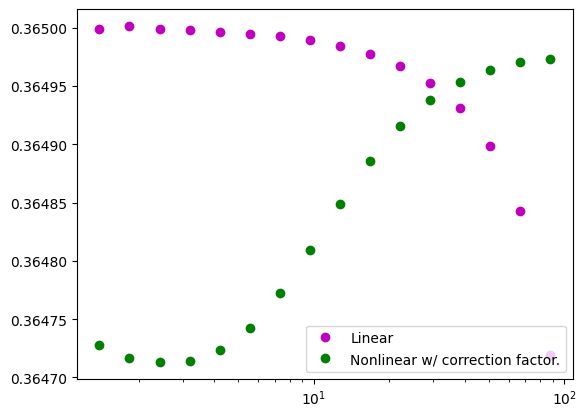

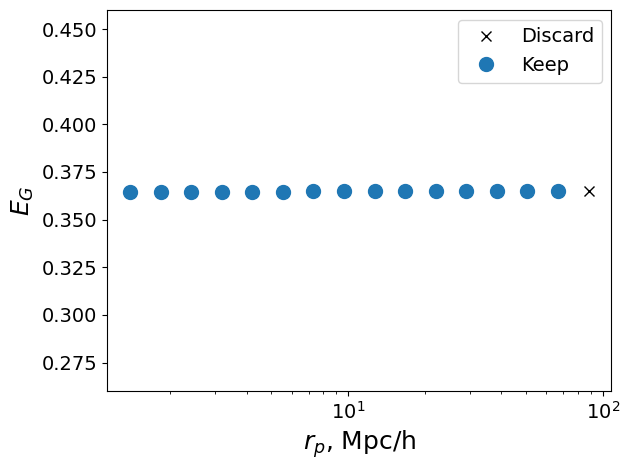

b1= 2.3201738034508015 b2= 1.163975860704669 bs= -0.37719251527165754
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
(16,)


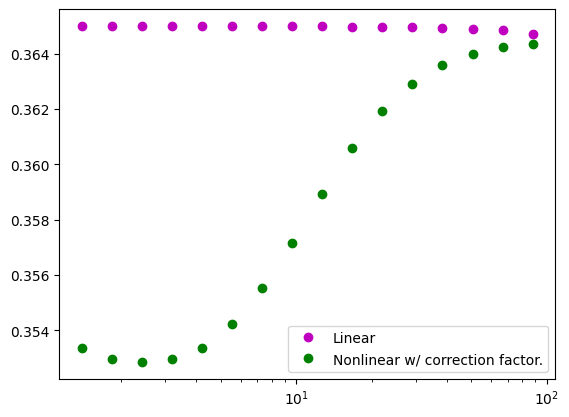

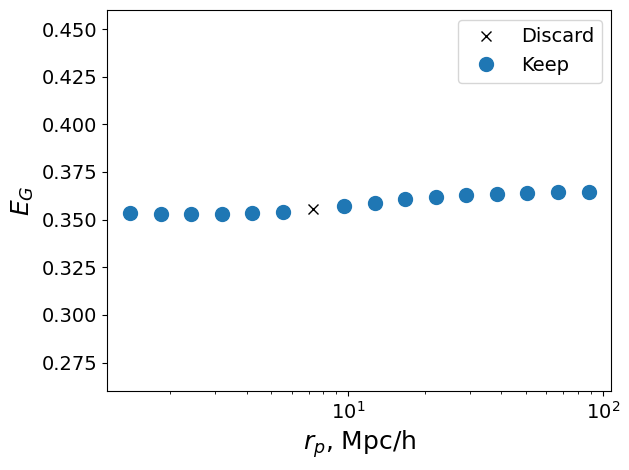

b1= 2.2674888702252503 b2= 1.0997223086011478 bs= -0.3621396772072144
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
(16,)


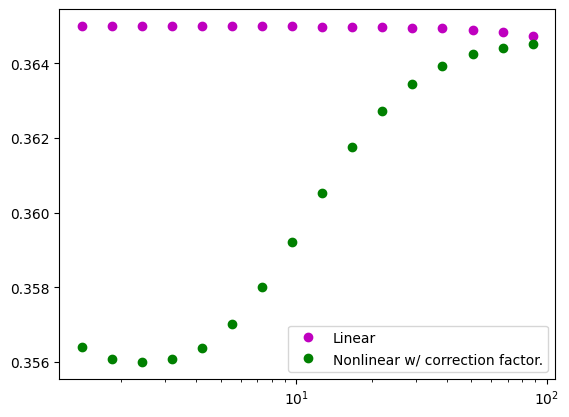

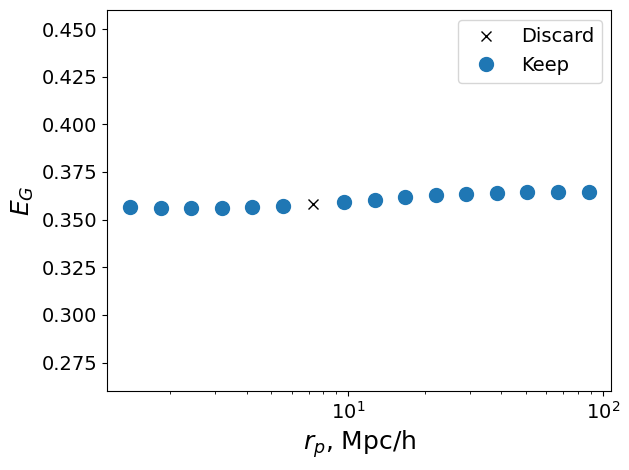

b1= 2.318906244323318 b2= 1.4027439962362669 bs= -0.37683035552094807
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
(16,)


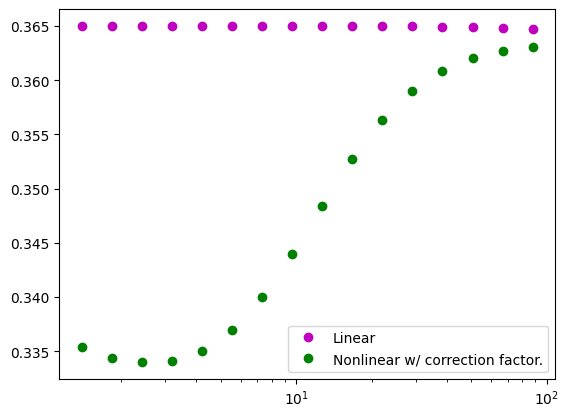

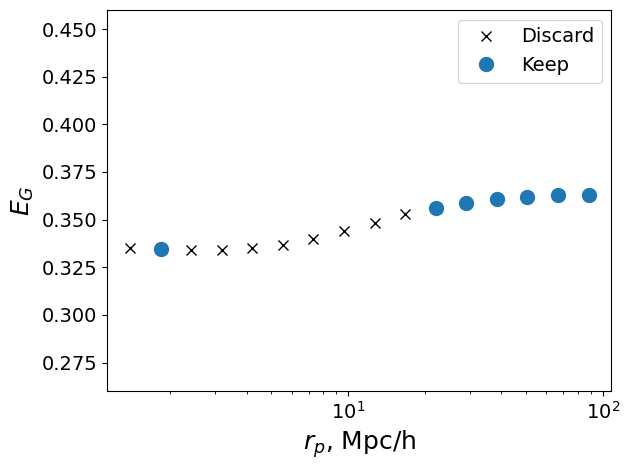

b1= 2.3682202202534945 b2= 0.30400502896433246 bs= -0.3909200629295698
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
(16,)


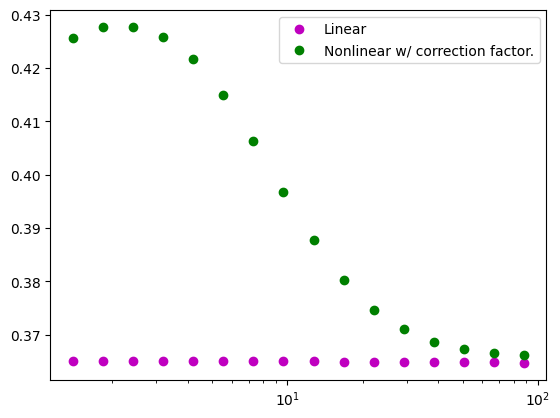

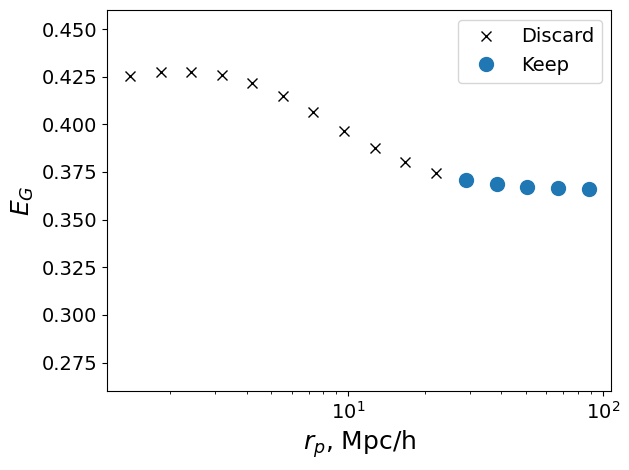

b1= 2.3579543283631628 b2= 0.5613361506636882 bs= -0.3879869509609037
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
(16,)


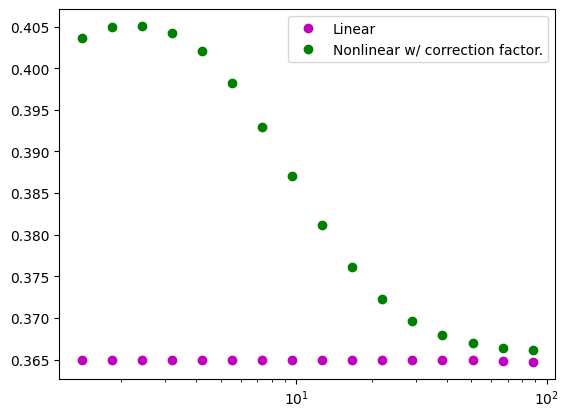

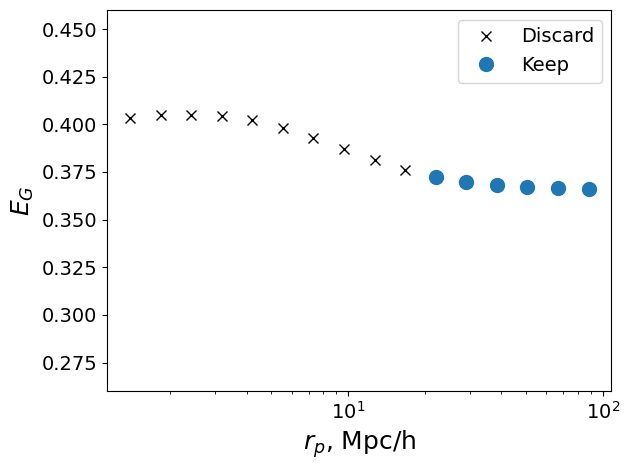

b1= 2.295104299975044 b2= 1.2890723957273498 bs= -0.3700297999928697
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
(16,)


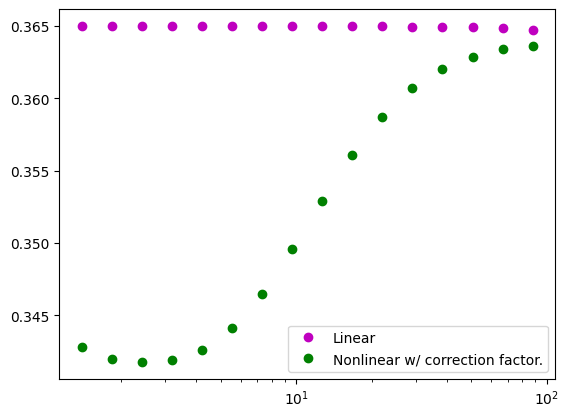

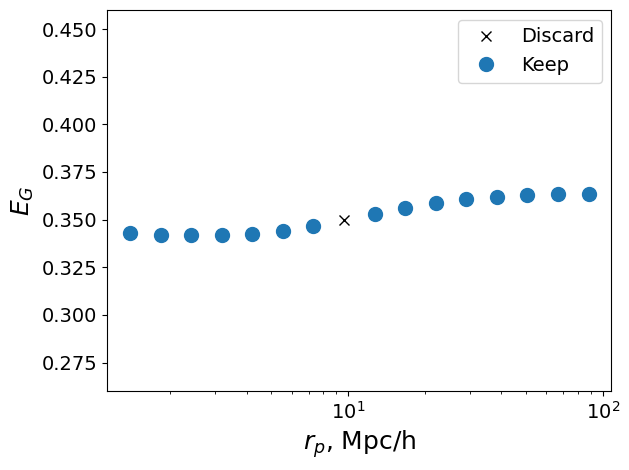

b1= 2.3198295731148177 b2= 0.8797262703312295 bs= -0.37709416374709076
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
(16,)


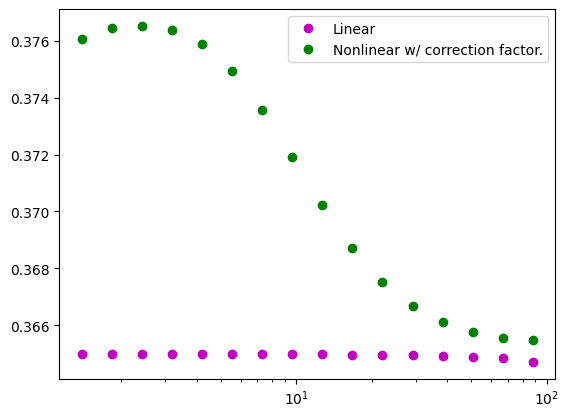

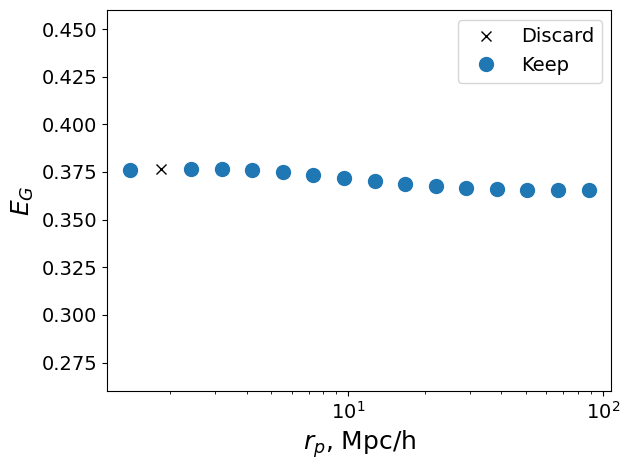

b1= 2.296126998443386 b2= 1.5544985189103147 bs= -0.37032199955525313
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
(16,)


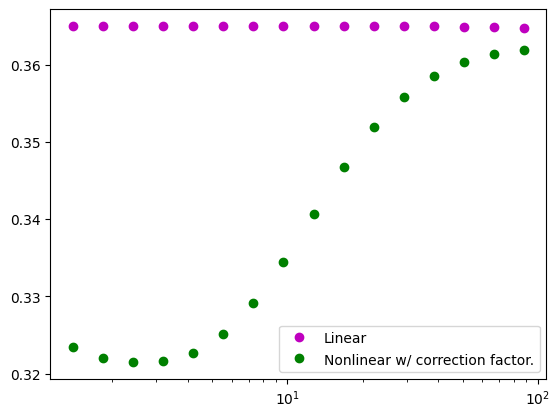

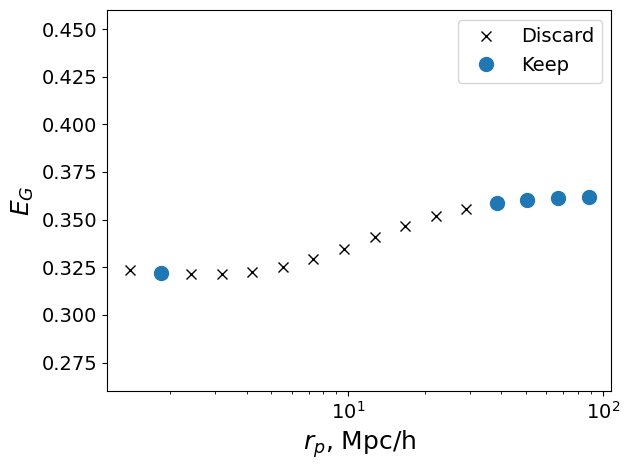

b1= 2.3589005422680533 b2= 0.9554012549840561 bs= -0.38825729779087237
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
(16,)


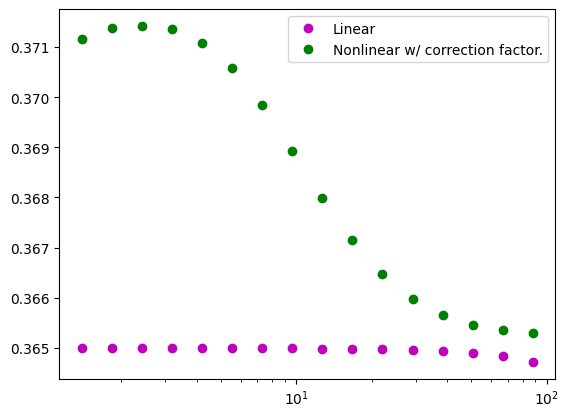

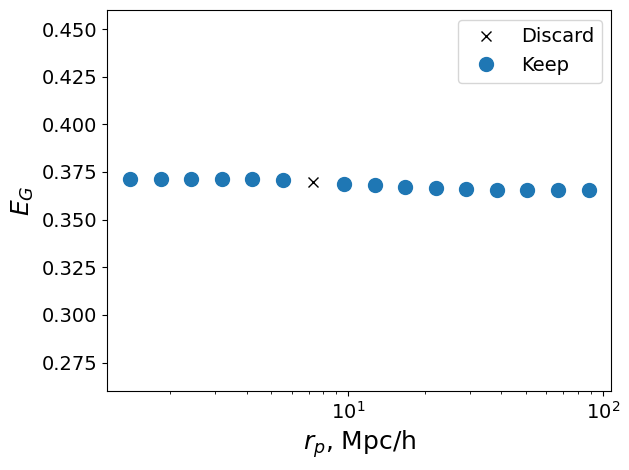

b1= 2.2869592962790857 b2= 0.8774824975946476 bs= -0.36770265607973873
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
(16,)


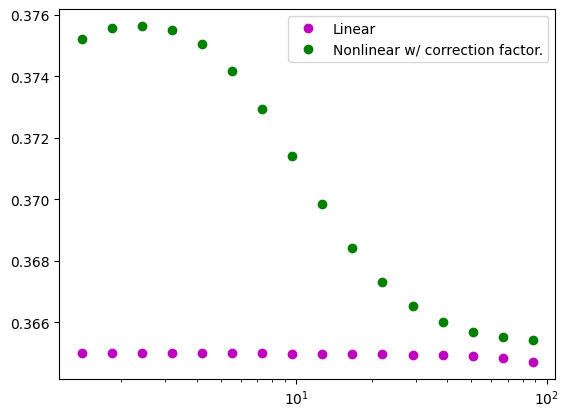

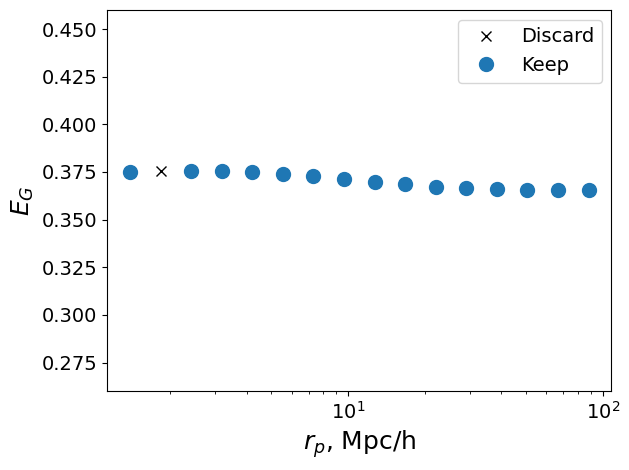

b1= 2.3376558366210496 b2= 1.359781815790694 bs= -0.38218738189172835
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356
(16,)


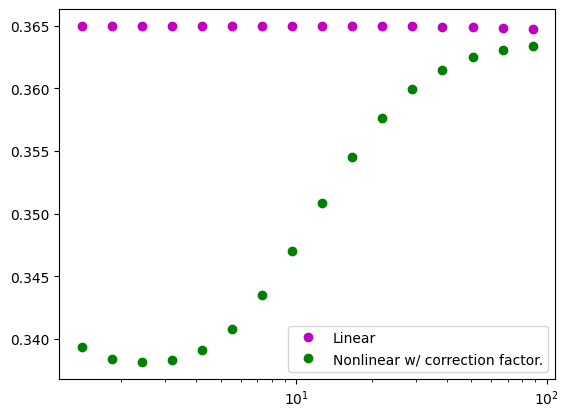

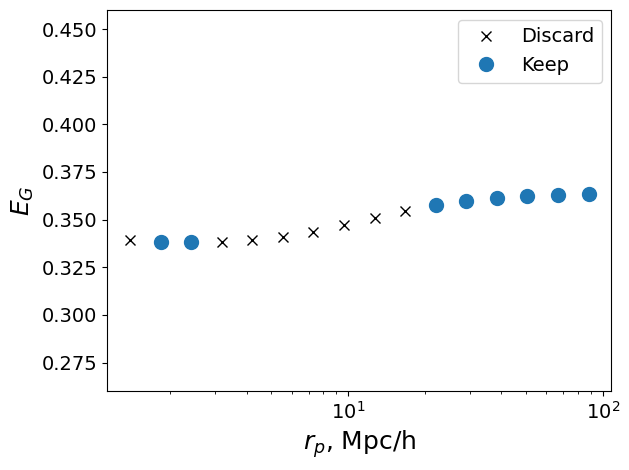

In [12]:
# Sample from the bias pars:
N_b_samp = 20
bias_pars_samp = np.random.multivariate_normal(bias_means, bias_cov, N_b_samp) # [b1,b2]

cut_inds_hold = [0]*N_b_samp
for i in range(0,N_b_samp):
    b1_LPT = bias_pars_samp[i,0]
    b2_LPT = bias_pars_samp[i,1]
    bs_LPT = 0 # Fixed to 0 in Kitinidis & White.

    b1 = 1.0 + b1_LPT
    b2 = b2_LPT + 8./21.*(b1_LPT)
    bs = bs_LPT - 2./7*(b1_LPT)

    params['b'] = b1
    params['b_2'] = b2
    params['b_s'] = bs

    print('b1=', b1, 'b2=', b2, 'bs=', bs)

    data_nl_EG = fid.E_G_corrected(params, C_b_mean, rp_bin_edges, rp0, lens, src, Pimax, endfilename)
    print(data_nl_EG.shape)

    plt.figure()
    plt.semilogx(rp_bin_c, data_lin_EG, 'mo', label='Linear')
    plt.semilogx(rp_bin_c, data_nl_EG, 'go', label='Nonlinear w/ correction factor.')
    plt.legend()
    plt.show()

    cut_inds_hold[i] = u.linear_scale_cuts_v2(data_nl_EG, data_lin_EG, cov_EG_corr, rp_bin_c)

    ind_keep_Eg = [ind for ind in range(0,len(rp_bin_c)) if ind not in cut_inds_hold[i]]
    rp_keep_Eg = rp_bin_c[ind_keep_Eg]
    Eg_keep = data_nl_EG[ind_keep_Eg]

    plt.figure()
    plt.semilogx(rp_bin_c, data_nl_EG, 'kx', markersize='7',label='Discard')
    plt.semilogx(rp_keep_Eg, Eg_keep, 'o', markersize='10',label='Keep')
    plt.ylabel('$E_G$',fontsize=18)
    plt.xlabel('$r_p$, Mpc/h',fontsize=18)
    plt.ylim(0.26,0.46)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.tight_layout()
    #plt.savefig('../plots/EG_linearscales_nLbias_correction.pdf')
    plt.show()

    
    

In [14]:
cut_inds_hold

[[6], [6], [0, 4, 5, 6, 7, 8]]

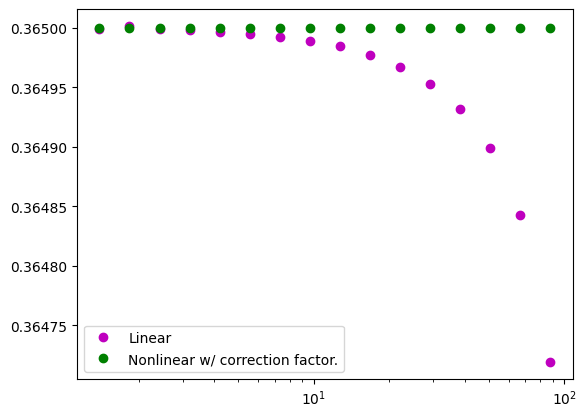

In [10]:
plt.figure()
plt.semilogx(rp_bin_c, data_lin_EG, 'mo', label='Linear')
plt.semilogx(rp_bin_c, data_nl_EG, 'go', label='Nonlinear w/ correction factor.')
plt.legend()
plt.show()

Get scale cuts for Eg

In [11]:
cut_inds_Eg = u.linear_scale_cuts_v2(data_nl_EG, data_lin_EG, Dcov_eg, rp_bin_c)

chi2_temp= [0.0002232  0.0002232  0.00022303 0.00021742 0.00022283 0.00022115 0.00021427 0.00021295 0.00022306 0.0002187  0.00022306 0.00022318 0.00020641 0.00022285 0.00021654 0.00015179]
ind_min= 15
cov= [[1.09473784e-03 1.35313414e-03 2.80589534e-04 1.76889432e-04 1.58360987e-04 1.42439248e-04 1.45663239e-04 1.45473837e-04 1.42125739e-04 1.34609182e-04 1.43525034e-04 1.30362003e-04 1.24622794e-04 1.22299075e-04 1.03045332e-04]
 [1.35313414e-03 1.68489686e-03 3.03981341e-04 1.76307204e-04 1.54657217e-04 1.34388057e-04 1.39527899e-04 1.39192264e-04 1.32369470e-04 1.23662546e-04 1.33477245e-04 1.17615688e-04 1.09732699e-04 1.09210952e-04 9.24566010e-05]
 [2.80589534e-04 3.03981341e-04 4.92930060e-04 2.50363163e-04 2.03971899e-04 2.19680192e-04 2.07314226e-04 1.96993462e-04 2.11551903e-04 2.02819733e-04 2.07686998e-04 2.05974483e-04 2.02513593e-04 1.92750155e-04 1.59947584e-04]
 [1.76889432e-04 1.76307204e-04 2.50363163e-04 2.78022588e-04 1.96452069e-04 1.95090505e-04 1.82761231e-04 1.8

In [12]:
print("cut indices=", cut_inds_Eg)

cut indices= []


For joint probes, we disect this to find the elements to cut for individual probes.

In [14]:
ind_keep_Eg = [ind for ind in range(0,len(rp_bin_c)) if ind not in cut_inds_Eg]
rp_keep_Eg = rp_bin_c[ind_keep_Eg]
Eg_keep = data_nl_EG[ind_keep_Eg]

Plot the data points this tells us to keep for joint probes (not many)

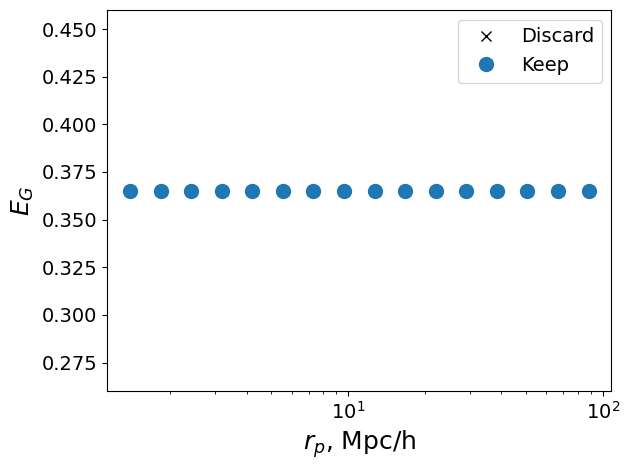

In [15]:
plt.figure()
plt.semilogx(rp_bin_c, data_nl_EG, 'kx', markersize='7',label='Discard')
plt.semilogx(rp_keep_Eg, Eg_keep, 'o', markersize='10',label='Keep')
plt.ylabel('$E_G$',fontsize=18)
plt.xlabel('$r_p$, Mpc/h',fontsize=18)
plt.ylim(0.26,0.46)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
#plt.savefig('../plots/EG_linearscales_nLbias_correction.pdf')
plt.show()

In [25]:
# Output the scale cuts in a readable format for later use.

cut = np.ones(len(rp_bin_c))
for i in range(0, len(rp_bin_c)):
    if i in cut_inds_Eg:
        cut[i] = 0

print('cut bins Eg=', cut_inds_Eg)
print('cut=', cut)

save_cuts = np.column_stack((rp_bin_c, cut))

np.savetxt('../txtfiles/scalecuts_nLbias_KitanidisWhite2022.dat', save_cuts, header='# rp bin centre,  cut this bin? 0 = Cut.')

cut bins Eg= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
cut= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]


In [18]:
# Check if the v1 version of the scale cuts actually does give a chi2<=1 when doing the cut more properly.

cut_EG_cov = np.delete(np.delete(Dcov_eg, cut_inds_Eg,axis=0),cut_inds_Eg,axis=1)
cut_EG_invcov = np.linalg.pinv(cut_EG_cov)
print('cut_EG_invcov=', cut_EG_invcov)
Eg_keep_lin = data_lin_EG[ind_keep_Eg]
delta_keep = Eg_keep - Eg_keep_lin
print('delta keep=', delta_keep)

chi2_eg_proper = np.dot(delta_keep, np.dot(cut_EG_invcov, delta_keep))
print('chi2 with v1 cut=', chi2_eg_proper)

cut_EG_invcov= [[ 125202.06501958 -128606.29448473   -3069.04900691    6862.99782975    3689.45017242   -1020.94751022]
 [-128606.29448473  267421.12726117 -149469.91733381   10783.93077262   10587.5306412    -5064.4483949 ]
 [  -3069.04900691 -149469.91733381  215467.6029004   -72575.21163344     433.39977782    5712.69037316]
 [   6862.99782975   10783.93077262  -72575.21163344   89941.9828391   -43933.0946901     6814.74779133]
 [   3689.45017242   10587.5306412      433.39977782  -43933.0946901    43461.70199089  -12104.01742626]
 [  -1020.94751022   -5064.4483949     5712.69037315    6814.74779133  -12104.01742626    5706.15422954]]
delta keep= [-3.90152130e-03 -1.79519498e-03 -5.99160836e-04  6.32652275e-06  2.60606873e-04  3.71351198e-04]
chi2 with v1 cut= 0.6984565916383918


Why does the nonlinear dip below the linear at intermediate scales? Edit: Figured this out, it's a physical feature due to the nonlinear impact from void growth at intermediate scales, see HMCode-2020 paper.

In [ ]:
wgg_lin = fid.wgg(params, rp_bin_c, lens, Pimax, endfilename, nonlin = False)
wgg_nonlin = fid.wgg(params, rp_bin_c, lens, Pimax, endfilename, nonlin = True)

In [ ]:
plt.figure()
plt.loglog(rp_bin_c, wgg_lin, 'mo', label='Linear, $w_{gg}$')
plt.loglog(rp_bin_c, wgg_nonlin, 'go', label='Nonlinear, $w_{gg}$')
plt.legend()
plt.savefig('../plots/wgg_lin_vs_nonlin_1000_Pimax200.pdf')
plt.show()

In [ ]:
k_lin, Pkgg_lin = np.loadtxt('../txtfiles/Pkgg_nonlin=False.dat', unpack=True)
k_nl, Pkgg_nl = np.loadtxt('../txtfiles/Pkgg_nonlin=True.dat', unpack=True)

In [ ]:
plt.figure()
plt.loglog(k_lin, Pkgg_lin, 'm', label='Linear$')
plt.loglog(k_nl, Pkgg_nl, 'g', label='Nonlinear')
plt.xlim(10**(-3), 10**(-1))
plt.ylim(10**4, 5*10**5)
plt.legend()
#plt.savefig('../plots/wgg_lin_vs_nonlin_1000_Pimax200.pdf')
plt.show()

In [ ]:
plt.figure()
plt.semilogx(k_lin, Pkgg_nl/Pkgg_lin)
plt.ylim(0.9,1.1)
plt.show()